### Impact and value of manual elevations - analysis & recommendation

In this analysis I am trying to understand the impact and value of manual elevations, especially if they increase customer lifetime value.

For our test we have **two groups**:
* A `treatment` (or experimental) group - Both automated and manual elevations were applied, with manual elevations taking priority
* B `control` group - Only automated elevations were applied to search results. Results purely based on the similarity of image metadata with the user query string. The automated elevations mechanism calculates at most 50 elevations per query.

For our *Dependent Variable* (i.e. what we are trying to measure), we are interested in capturing the `conversion rate` - number of licenses bought.

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [2]:
def show_stats(column):
    agg = ab_test.groupby(column).agg(count_searches=('search_id',np.size),
                                                             sum_elevations = ('num_elevations',np.sum), 
                                                             sum_all_clicks = ('num_clicks',np.sum),
                                                             sum_all_exports = ('num_exported_results',np.sum),
                                                             sum_all_licenses = ('num_licenses',np.sum))
    agg['click_rate'] = (agg['sum_all_clicks'] / agg['count_searches'])
    agg['export_rate'] = (agg['sum_all_exports'] / agg['count_searches'])
    agg['license_rate'] = (agg['sum_all_licenses'] / agg['count_searches'])
    agg = agg[['click_rate', 'export_rate', 'license_rate']]
    print(agg.sort_values(by='license_rate',ascending=False).head(10))

## Read Data

In [3]:
df = pd.read_csv('manual_elevations_experiment_data.csv')

df.head()

,experiment_day,search_id,user_id,experiment_group,user_tier,query,media_types,num_elevations,num_clicks,num_exported_results,num_licenses
0,65,AOGFabmo,51b2325a,B,free,speech bubble,RV,0,1,0,0
1,65,AIT27lH-,97c2ab50,A,paid,line,RV,80,2,1,0
2,65,AMgr6dQc,d626988c,B,free,button,RV,0,1,0,0
3,65,WKgECNwN,8bcaf483,B,free,apple,RV,0,0,0,0
4,65,dzdr0OMT,ca240171,A,paid,banner,RV,80,1,1,0


## Data Cleaning

In [4]:
df = df.drop_duplicates(subset='search_id') #deleting two duplicated search_id's. A bug?
df = df[df['experiment_group']!='S'] #keeping only A&B groups

In [5]:
df['experiment_group'] = df['experiment_group'].replace('A','treatment')
df['experiment_group'] = df['experiment_group'].replace('B','control')

In [6]:
control_sample = df[df['experiment_group'] == 'control'][df['num_elevations']==0]
#deleting dirty data
treatment_sample = df[df['experiment_group'] == 'treatment']
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

/var/folders/7h/jhtspggj63166rh3c9ysbdnm0000gn/T/ipykernel_80458/2118327935.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_sample = df[df['experiment_group'] == 'control'][df['num_elevations']==0]


## EDA

In [7]:
ab_test.head(5)

,experiment_day,search_id,user_id,experiment_group,user_tier,query,media_types,num_elevations,num_clicks,num_exported_results,num_licenses
0,65,AOGFabmo,51b2325a,control,free,speech bubble,RV,0,1,0,0
1,65,AMgr6dQc,d626988c,control,free,button,RV,0,1,0,0
2,65,WKgECNwN,8bcaf483,control,free,apple,RV,0,0,0,0
3,65,AJtAg_5K,972122eb,control,paid,line,RV,0,3,0,0
4,65,ANeptGYr,fb62dec1,control,free,square,RV,0,1,0,0


**experiment_day** - numeric - 1-71 days, median: 35

**search_id** - hashed ID, 1688375 searches

**user_id** - hashed ID, one user has many searches, 560052 users 

**user_tier** - 70% free, 30% paid

**query** - categories, there are more and less popular ones (arrow 7%, heart, line, instagram, flowers around 4%), 335 distinct 

**media_types** - RV is 99%, 3 categories, highly correlated with num_elevations

**experiment_group** - highly correlated with num_elevations

**num_elevations** - from 0 to 410, median 0, 50% zeros

**num_clicks**, from 0 to 203, median 1, 45% zeros, highly correlated with num_exported_results

**num_exported_results**, from 0 to 50, median 0, 72% zeros

**num_licenses** - from 0 to 53, median 0, highly skewed, 97% zeros, highly correlated with num_exported_results 

In [8]:
ab_test['experiment_group'].value_counts() #both groups are of similar size

control      847614
treatment    840701
Name: experiment_group, dtype: int64

In [9]:
show_stats('experiment_group')  #control group has higher license_rate

                  click_rate  export_rate  license_rate
experiment_group                                       
control             1.132066     0.325828      0.033958
treatment           1.071654     0.334107      0.029365


In [10]:
show_stats('user_tier') #definitely higher license rate for pad tier

           click_rate  export_rate  license_rate
user_tier                                       
paid         1.157110     0.342475      0.099675
free         1.078233     0.324554      0.002371


In [11]:
show_stats('media_types') #V has highest license rate

             click_rate  export_rate  license_rate
media_types                                       
V              1.252790     0.304694      0.084322
RV             1.100285     0.330416      0.031532
R              1.397396     0.235686      0.022193


In [12]:
show_stats('query') #Medical icons, emails, snowflake and food have the highest license rate

               click_rate  export_rate  license_rate
query                                               
Medical icons    6.000000     1.000000      1.000000
email            1.030783     0.446570      0.403474
snowflake        1.881748     0.526992      0.334190
Food Icon        0.666667     0.666667      0.333333
vote             0.916515     0.281307      0.294918
person           0.787596     0.314783      0.263806
clock            0.963309     0.366592      0.253621
sun              1.008888     0.345947      0.242796
website          0.697439     0.242588      0.234501
baby             1.097468     0.346835      0.230696


In [13]:
ab_test.groupby('query')['query'].count().sort_values(ascending=True).head(30)
#for the extended analysis, the key words should be cleaned (whitespaces,errors,signs,small vs big letters)

query
Medical icons                      1
 vintage                           1
hospitality icons                  1
School icons                       1
School icon                        1
Music icons                        1
Music Icons                        1
Music Icon                         1
Free photo                         1
Health icon                        1
Gradients                          2
Graph                              2
 brand:BABCTFGu9Rg^100 tropical    2
Lifestyle                          2
Food icons                         2
Happy New Year                     2
Charts                             2
Social media icon                  2
Graphs                             3
Landscapes                         3
Music icon                         3
Illustration                       3
Valentines Day                     3
Tombstone                          4
Food Icon                          6
web wireframes                     6
Valentines day                  

In [14]:
ab_test.groupby(['user_id'])['experiment_day'].nunique().sort_values(ascending=False).head() 
#Some users were active almost everyday. What is their characteristics?

user_id
73fda8af    65
303ee6c4    58
a112b0a0    56
daf76cf8    52
fd5e10ac    52
Name: experiment_day, dtype: int64

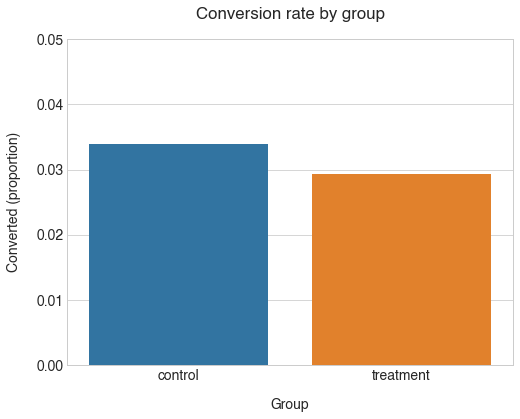

In [15]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['experiment_group'], y=ab_test['num_licenses'], ci=False)

plt.ylim(0, 0.05)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Creating test dataset

Creating dataset which will all samples having the same value for query (most popular - ARROW), user tier (FREE) and media type (MOST POPULAR - RV). 
This way the result of the test would not be influenced by these variables and we still keep sample big.

In [16]:
test_free = ab_test[ab_test['query']=='arrow'][ab_test['user_tier']=='free'][ab_test['media_types']=='RV'] 
test_premium = ab_test[ab_test['query']=='arrow'][ab_test['user_tier']=='paid'][ab_test['media_types']=='RV'] 

/var/folders/7h/jhtspggj63166rh3c9ysbdnm0000gn/T/ipykernel_80458/1638000894.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_free = ab_test[ab_test['query']=='arrow'][ab_test['user_tier']=='free'][ab_test['media_types']=='RV']
/var/folders/7h/jhtspggj63166rh3c9ysbdnm0000gn/T/ipykernel_80458/1638000894.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_premium = ab_test[ab_test['query']=='arrow'][ab_test['user_tier']=='paid'][ab_test['media_types']=='RV']


### Experimentation (Free tier)

In [17]:
conversion_rates = test_free.groupby('experiment_group')['num_licenses']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
experiment_group,,,
control,0.005,0.080,0.000
treatment,0.002,0.049,0.000


In [18]:
perc = (conversion_rates['conversion_rate'][0] - conversion_rates['conversion_rate'][1])/conversion_rates['conversion_rate'][0]
print('Percentage difference: ', round(perc,3))

Percentage difference:  0.631


Judging by the stats above, it does look like **control group performs better**, approx. **0.5% vs. 0.2%**.

Since we have a very large sample, we can use the normal approximation for calculating our $p$-value (i.e. z-test). 


In [19]:
control_results = test_free[test_free['experiment_group'] == 'control']['num_licenses']
treatment_results = test_free[test_free['experiment_group'] == 'treatment']['num_licenses']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 8.41
p-value: 0.000
ci 95% for control group: [0.005, 0.006]
ci 95% for treatment group: [0.002, 0.002]


Since our $p$-value is below our $\alpha$=0.05, we reject the null hypothesis $H_0$, which means that our new approach did perform significantly different 

Additionally, if we look at the confidence interval for the `treatment` group we notice that it is around 0.2%.

### Experimentation (Premium tier)

In [20]:
conversion_rates = test_premium.groupby('experiment_group')['num_licenses']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
experiment_group,,,
control,0.169,0.461,0.004
treatment,0.074,0.319,0.003


In [21]:
perc = (conversion_rates['conversion_rate'][0] - conversion_rates['conversion_rate'][1])/conversion_rates['conversion_rate'][0]
print('Percentage difference: ', round(perc,3))

Percentage difference:  0.565


Judging by the stats above, it does look like **control group performes much better**, approx. **17% vs. 7%**.

Since we have a very large sample, we can use the normal approximation for calculating our $p$-value (i.e. z-test). 

In [22]:
control_results = test_premium[test_premium['experiment_group'] == 'control']['num_licenses']
treatment_results = test_premium[test_premium['experiment_group'] == 'treatment']['num_licenses']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 26.24
p-value: 0.000
ci 95% for control group: [0.163, 0.175]
ci 95% for treatment group: [0.069, 0.078]


Since our $p$-value is below our $\alpha$=0.05, we reject the null hypothesis $H_0$, which means that our new approach did perform significantly different 

Additionally, if we look at the confidence interval for the `treatment` group we notice that it is around 7-8%.

### Ideas for the longer analysis:
- Tree-based machine learning models to understand features better and try to predict customer value (amount of bought licenses) using demographics and usage behaviors
- Customer segmentation using unsupervised models (customer clustering)
- Trying Three-way Anova or Multifactorial Anova to understand each feature's importance and impact
- Taking into account in the analysis: user's activity during the experimentation period (number of events, day by day, increasing or decreasing, influence of weekends and day time) and demographics data
- Analysing characteristics of users which are very active (45-70 days of activity) versus medium active (20 - 44 days) to low activity (up to 19 days).
- For the extended analysis, the key words should be cleaned (whitespaces,errors,signs,small vs big letters) and could be clustered into topics which could be analysed -> the most common topics, the best selling topics

### Recommendations
- Automated Elevations perform better, in the overall they have higher license rate. However, it would be worth checking the rate in detail looking at different queries and adapt the solution based of the situation.
- Paid users have definitely higher license rate, most probably because they already find the service worth paying and they use the possibilities it gives. 
- There are some queries that have the highest license rate, like: medical icons, emails, snowflake and food. It might be worth to expand this topics more since they are popular among users who decide to pay for the license. 